## SDM274 Assignment 03 - Perceptron

**Requirements**

The wine.data dataset contains a total of 178 data points, each representing a wine sample with a class label and 13 features, which are chemical indicators such as alcohol content and malic acid concentration. More detailed information can be found the file titled wine.names.

Remove one class of wine samples from the dataset, retaining the other two classes to generate a new dataset. Use a Perceptron to address the binary classification problem of wine.

1.Write code to split the dataset into a training set and a test set in the ratio of (0.7, 0.3).

2.Write separate Perceptron codes for Batch update and Stochastic update to train the model.

3.Use the trained model to make predictions on the test set, and write code to evaluate the model's classification performance using Accuracy, recall, precision, and F1 score.

Use the following packages mainly:
- Numpy for matrix operations and data manipulation.
- Pandas for data manipulation.
- Matplotlib for data visualization.

In [1067]:
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
# %matplotlib ipympl

Then implement the Perceptron algorithm in **BinaryPerceptron** class. Like the implementation in the previous assignment, we add SGD, BGD and MBGD methods to train the model; support min-max normalization and mean normalization:

In [1068]:
class OptimizerType(Enum):
    SGD = 1
    BGD = 2
    MBGD = 3

class NormalizationType(Enum):
    NONE = 0
    MINMAX = 1
    MEAN = 2

class BinaryPerceptron:
    def __init__(self, dim = 1, learning_rate = 0.0001, max_iterations = 1000, tolerance = None, no_improve_threshold = 6, normalization_type = NormalizationType.NONE, optimizer_type = OptimizerType.SGD, batch_size = None):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.normalization_type = normalization_type
        self.tolerance = tolerance
        self.no_improve_threshold = no_improve_threshold

        self.optimizer_type = optimizer_type
        self.batch_size = batch_size
        if optimizer_type == OptimizerType.MBGD and batch_size is None:
            raise ValueError("batch_size should be specified for MBGD.")

        self.w = np.zeros(dim + 1)
        
        self.loss_history = None
        self.w_history = None
    
    @staticmethod
    def extend_X(X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _min_max_normalize(self, X, record_params = False):
        if record_params:
            self.X_min, self.X_max = np.min(X, axis = 0), np.max(X, axis = 0)
        with np.errstate(divide = 'ignore', invalid = 'ignore'):
            X_normalized = (X - self.X_min) / (self.X_max - self.X_min)
        return np.where(np.isnan(X_normalized), X, X_normalized)

    def _mean_normalize(self, X, record_params = False): # TODO
        if record_params:
            self.X_mean, self.X_std = np.mean(X, axis = 0), np.std(X, axis = 0)
        with np.errstate(divide = 'ignore', invalid = 'ignore'):
            X_normalized = (X - self.X_mean) / self.X_std
        return np.where(np.isnan(X_normalized), X, X_normalized)
    
    def _normalize(self, X, record_params = False):
        if self.normalization_type == NormalizationType.MINMAX:
            return self._min_max_normalize(X, record_params)
        elif self.normalization_type == NormalizationType.MEAN:
            return self._mean_normalize(X, record_params)
        return X

    @staticmethod
    def _predict(X, w):
        X_ext = BinaryPerceptron.extend_X(X)
        return np.sign(X_ext @ w).astype(int)
    
    def predict(self, X, w = None):
        w = self.w if w is None else w
        X_norm = self._normalize(X)
        return BinaryPerceptron._predict(X_norm, w)
    
    @staticmethod
    def _loss(X, t, w):
        X_ext = BinaryPerceptron.extend_X(X)
        l = -t * (X_ext @ w)
        false_flag = l > 0
        return np.mean(l[false_flag]) if np.sum(false_flag) > 0 else 0 # mean value of the loss on the misclassified samples
    
    def loss(self, X, t, w = None):
        w = self.w if w is None else w
        X_norm = self._normalize(X)
        return BinaryPerceptron._loss(X_norm, t, w)

    @staticmethod
    def _gradients(X, t, w):
        X_ext = BinaryPerceptron.extend_X(X)
        false_flag = t * (X_ext @ w) <= 0
        return np.mean(-t[false_flag].reshape(-1, 1) * X_ext[false_flag], axis = 0) if np.sum(false_flag) > 0 else np.zeros_like(w)
    
    def optimize(self, X, t):
        # Normalization for the first time
        X_norm = self._normalize(X, record_params = True)

        # Initialize history
        if self.tolerance is not None:
            last_loss = np.inf
        self.w_history = []
        self.loss_history = []

        # Optimization loop
        no_improve_count = 0
        for i in range(self.max_iterations):
            # Select samples
            _X, _t = X_norm, t
            if self.optimizer_type == OptimizerType.SGD:
                indices = np.random.randint(0, _X.shape[0])
                _X, _t = _X[indices:(indices + 1)], _t[indices:(indices + 1)]
            elif self.optimizer_type == OptimizerType.MBGD:
                indices = np.random.choice(_X.shape[0], self.batch_size, replace = False)
                _X, _t = _X[indices], _t[indices]

            # Calculate gradients on the selected samples
            grads = self._gradients(_X, _t, self.w)

            # Update weights
            self.w -= self.learning_rate * grads

            # Record history
            new_loss = self._loss(X_norm, t, self.w)
            self.w_history.append(self.w.copy())
            self.loss_history.append(new_loss)

            # Calculate overall loss and check convergence
            if self.tolerance is not None:
                if np.abs(new_loss - last_loss) < self.tolerance:
                    no_improve_count += 1
                    if no_improve_count >= self.no_improve_threshold:
                        print(f"Converged at iteration {i}.")
                        break
                else:
                    no_improve_count = 0
                last_loss = new_loss

Data splitting utility function **random_split** modified from HA-02.pdf:

In [1069]:
def random_split(X, y, test_size = 0.2, seed = None):
    if seed is not None:
        np.random.seed(seed)

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split_index = int(len(X) * (1 - test_size))
    train_indices, test_indices = indices[:split_index], indices[split_index:]

    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, y_train, X_test, y_test

And finally a utility function **show_results** to print the optimized results and the evaluation metrics (accuracy, recall, precision, f1_score), as well as the loss curve (if the parameter show_plot is set to True):

In [1070]:
def show_results(model, X_train, t_train, X_test, t_test, show_plot = False, fig_scale = 2):
    # Optimization results
    print('Optimized result:\t', model.w)
    print('Optimized loss:\t', model.loss(X_train, t_train))

    # Test results (TODO)
    t_pred_train = model.predict(X_train)
    t_pred_test = model.predict(X_test)
    accuracy_train = np.mean(t_pred_train == t_train)
    accuracy_test = np.mean(t_pred_test == t_test)
    print('Accuracy (Train):\t', accuracy_train)
    print('Accuracy (Test):\t', accuracy_test)
    recall_train = np.mean(t_pred_train[t_train == 1] == 1)
    recall_test = np.mean(t_pred_test[t_test == 1] == 1)
    print('Recall (Train):\t\t', recall_train)
    print('Recall (Test):\t\t', recall_test)
    precision_train = np.mean(t_train[t_pred_train == 1] == 1)
    precision_test = np.mean(t_test[t_pred_test == 1] == 1)
    print('Precision (Train):\t', precision_train)
    print('Precision (Test):\t', precision_test)
    f1_train = 2 * precision_train * recall_train / (precision_train + recall_train)
    f1_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    print('F1 Score (Train):\t', f1_train)
    print('F1 Score (Test):\t', f1_test)

    if show_plot:
        # Plot
        fig = plt.figure(figsize = (16 * fig_scale, 4.5 * fig_scale))
        fig.suptitle(f'(learning_rate = {model.learning_rate}, max_iterations = {model.max_iterations}, tolerance = {model.tolerance}, normalization_type = {model.normalization_type}, optimizer_type = {model.optimizer_type}{", batch_size = " + str(model.batch_size) if model.optimizer_type == OptimizerType.MBGD else ""})', fontsize = 8 * fig_scale)

        # Loss curve
        ax = fig.add_subplot(111)
        ax.plot(model.loss_history)
        ax.tick_params(labelsize = 6 * fig_scale)
        ax.set_xlabel('Iteration', fontsize = 6 * fig_scale)
        ax.set_ylabel('Loss', fontsize = 6 * fig_scale)
        ax.set_title('Loss Curve', fontsize = 8 * fig_scale)

        # Show plot
        plt.show()

Load the dataset from `wine.data` and split it into training and testing sets with a ratio of 0.3 for test data. And then we drop one class of wine samples (class 3) to generate a binary classification problem. Let class 1 be the negative class and class 2 be the positive class:

In [1071]:
# Load data
wine_csv = pd.read_csv('wine.data', header = None)
t_train = wine_csv[0].values
X_train = wine_csv.drop(0, axis = 1).values

# drop the data with label 3, change label 1 to -1 and label 2 to 1
drop_flag = t_train != 3
X_train, t_train = X_train[drop_flag], t_train[drop_flag]
t_train[t_train == 1] = -1
t_train[t_train == 2] = 1

# split the data
X_train, t_train, X_test, y_test = random_split(X_train, t_train, test_size = 0.3, seed = 42)
print(X_train.shape, t_train.shape, X_test.shape, y_test.shape)

(91, 13) (91,) (39, 13) (39,)


Use the `BinaryPerceptron` class to train the model. First we try the Stochastic Gradient Descent (SGD) method without normalization:

Converged at iteration 68.
Optimized result:	 [ 0.011     0.11282   0.01829   0.02125   0.2521    0.977     0.01396
  0.00618   0.00535   0.01461   0.00171   0.011728  0.02178  -0.22    ]
Optimized loss:	 35.48866054199994
Accuracy (Train):	 0.7142857142857143
Accuracy (Test):	 0.5641025641025641
Recall (Train):		 0.43478260869565216
Recall (Test):		 0.32
Precision (Train):	 1.0
Precision (Test):	 1.0
F1 Score (Train):	 0.6060606060606061
F1 Score (Test):	 0.48484848484848486


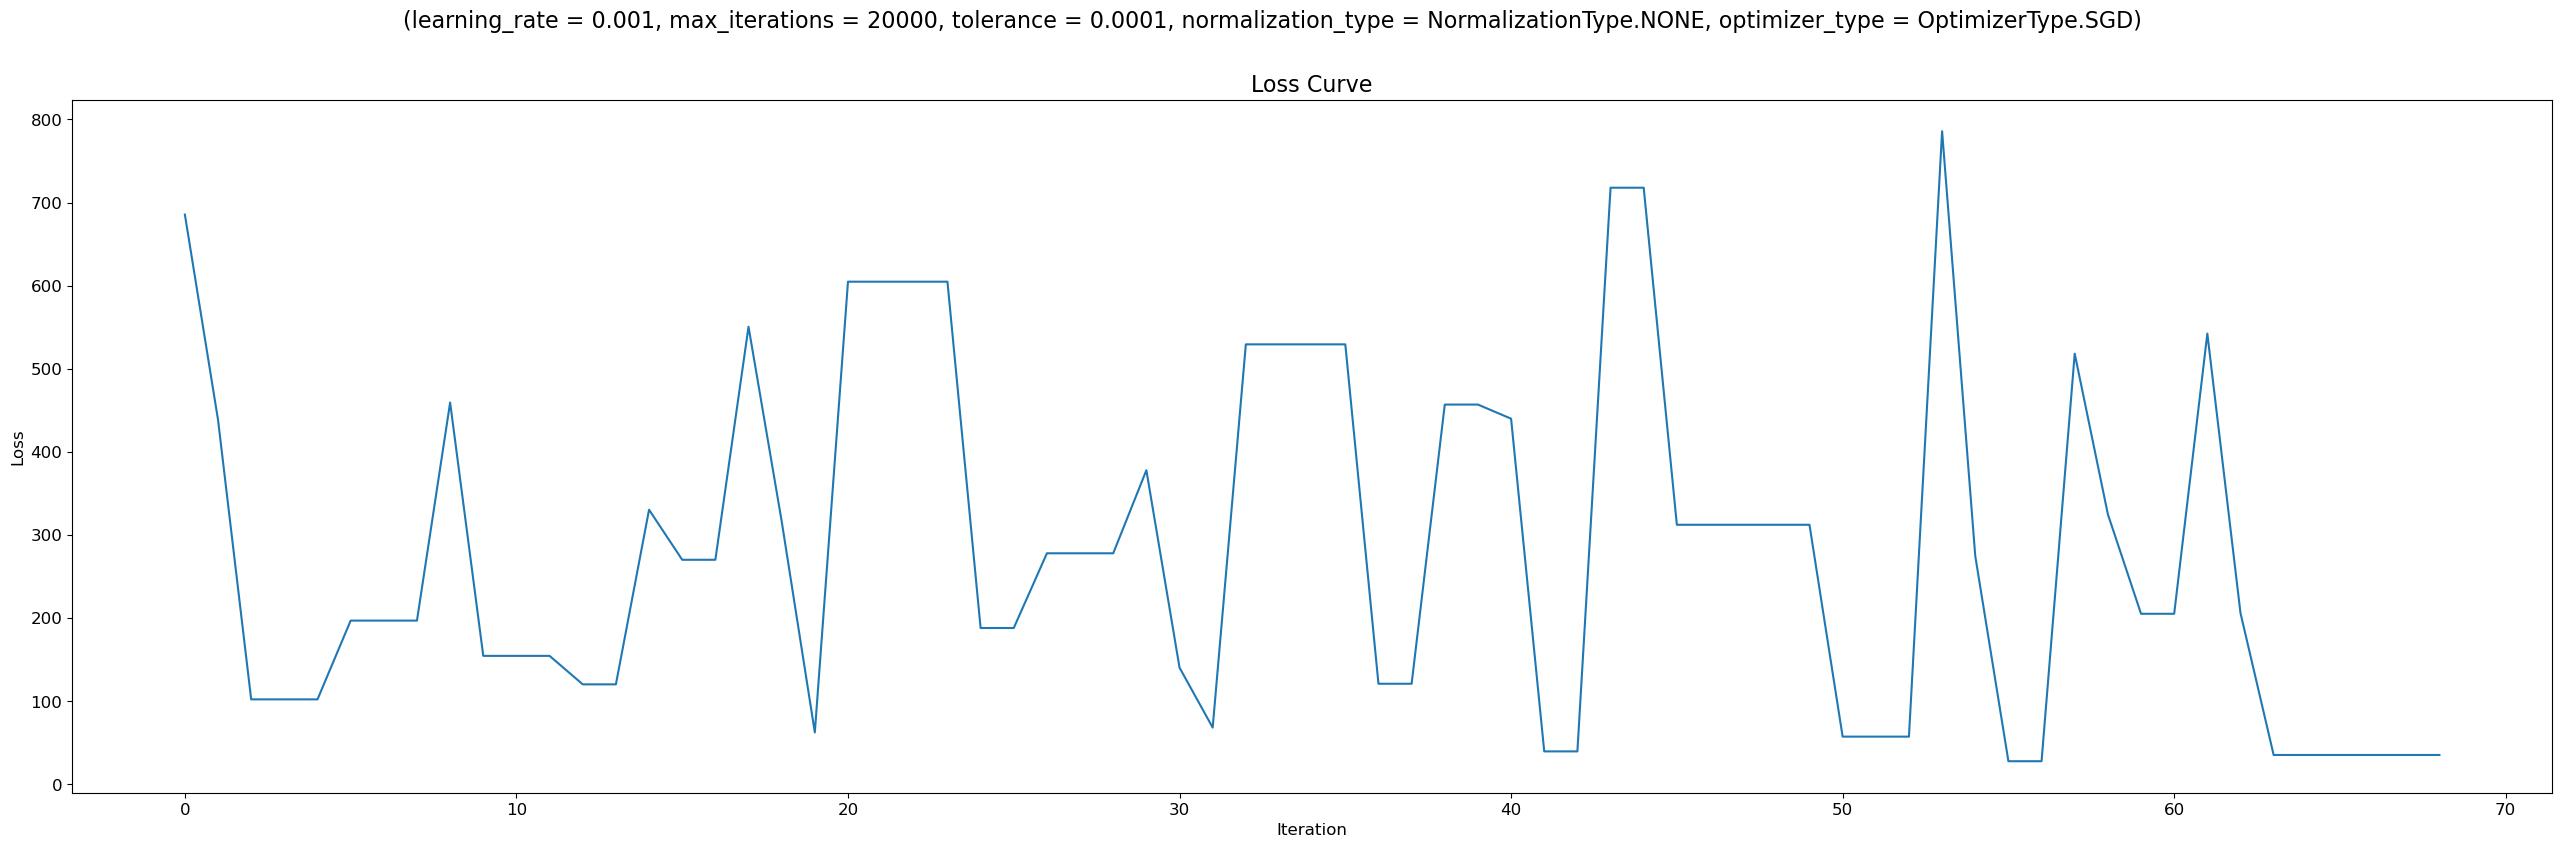

In [1072]:
model = BinaryPerceptron(
    dim = X_train.shape[1],
    learning_rate = 0.001,
    max_iterations = 20000,
    tolerance = 1e-4,
    no_improve_threshold = 5,
    normalization_type = NormalizationType.NONE,
    optimizer_type = OptimizerType.SGD
)
model.optimize(X_train, t_train)
show_results(model, X_train, t_train, X_test, y_test, show_plot = True)

The result is not good, especially the accuracy on the test set is low. We can try to normalize the data using the min-max normalization method:

Converged at iteration 15.
Optimized result:	 [ 0.001      -0.00081579  0.00063686  0.00010526  0.00098925  0.00057609
 -0.00049455 -0.00087415  0.00105769 -0.00053797 -0.00011286  0.00033333
 -0.0006888  -0.00025749]
Optimized loss:	 0.0003605042742006382
Accuracy (Train):	 0.8021978021978022
Accuracy (Test):	 0.8461538461538461
Recall (Train):		 0.9565217391304348
Recall (Test):		 0.96
Precision (Train):	 0.7333333333333333
Precision (Test):	 0.8275862068965517
F1 Score (Train):	 0.8301886792452831
F1 Score (Test):	 0.888888888888889


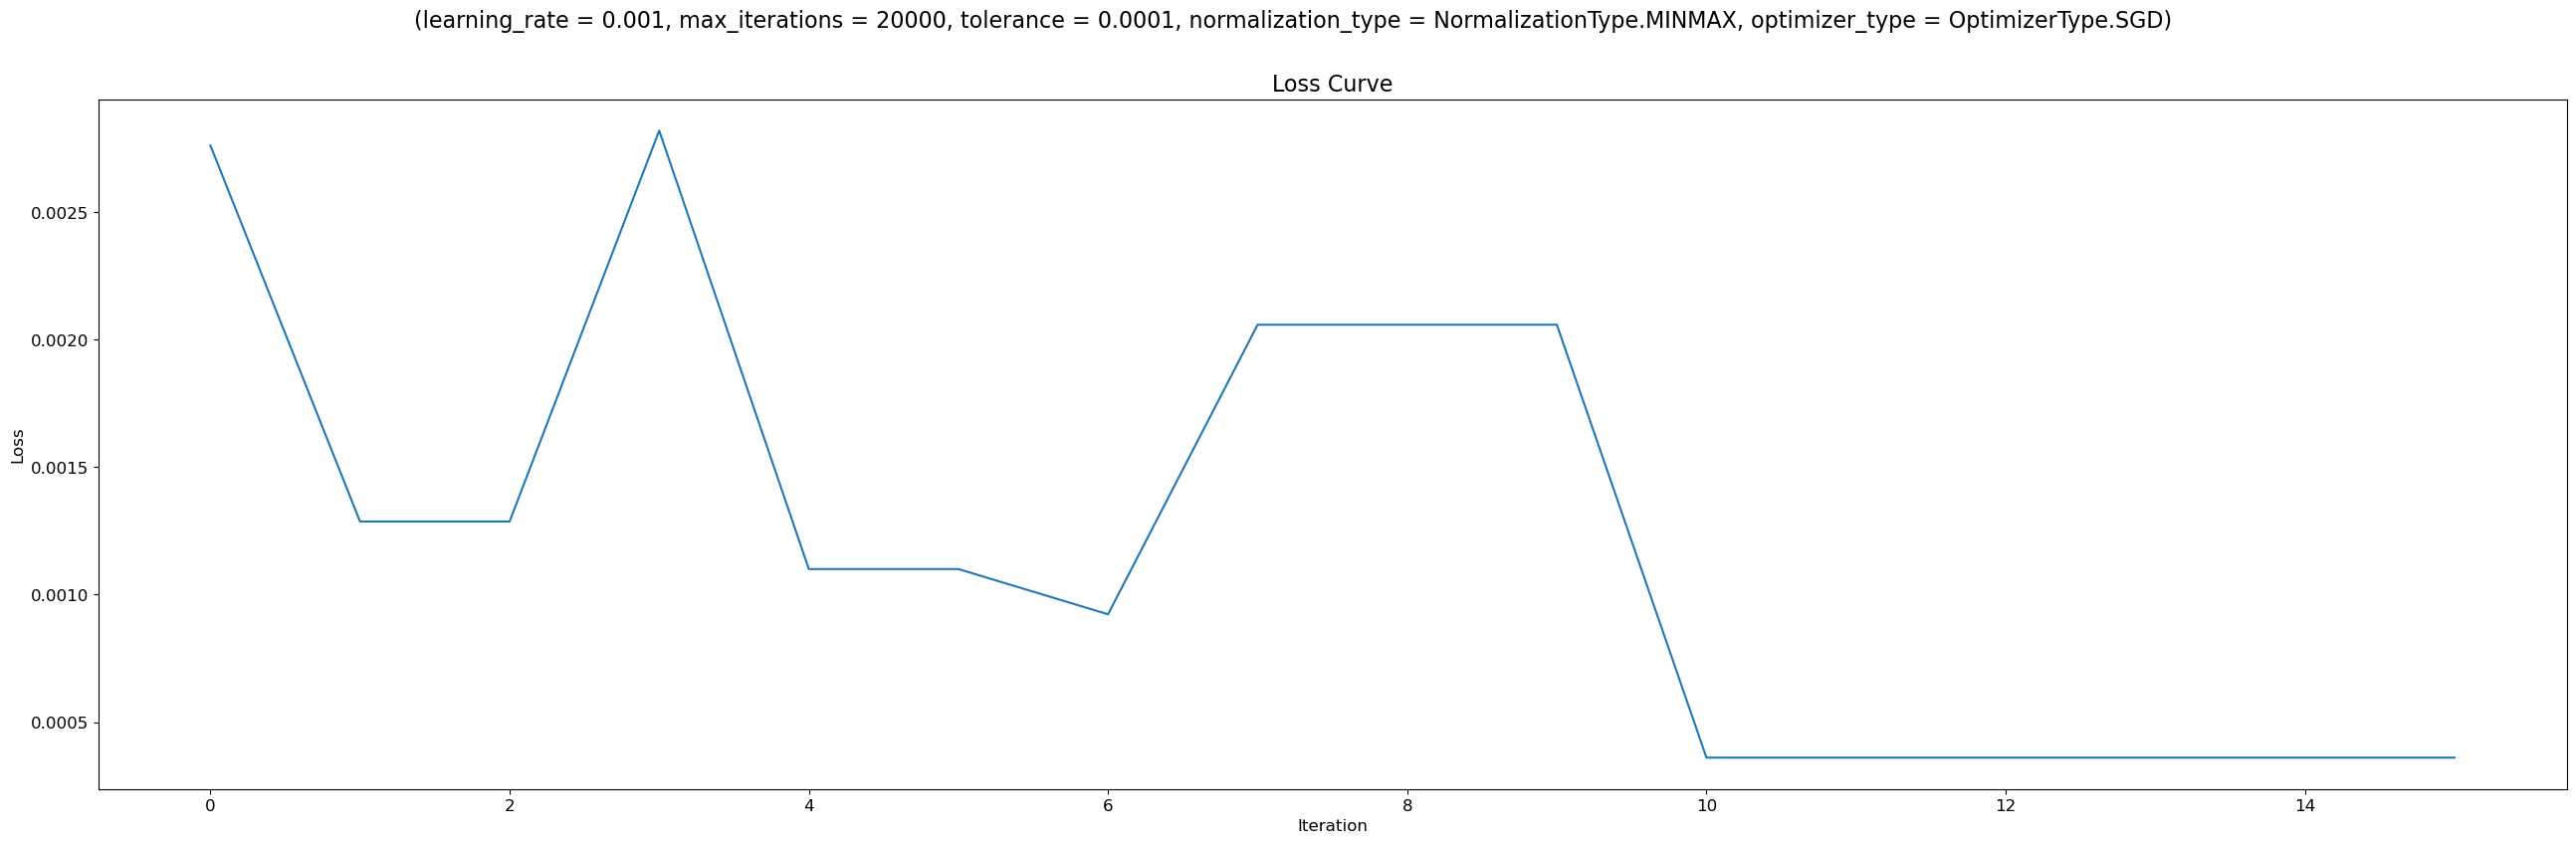

In [1073]:
model = BinaryPerceptron(
    dim = X_train.shape[1],
    learning_rate = 0.001,
    max_iterations = 20000,
    tolerance = 1e-4,
    no_improve_threshold = 5,
    normalization_type = NormalizationType.MINMAX,
    optimizer_type = OptimizerType.SGD
)
model.optimize(X_train, t_train)
show_results(model, X_train, t_train, X_test, y_test, show_plot = True)

Now the accuracies on both the training and test sets are improved. Then we can try the Batch Gradient Descent (BGD) method with min-max normalization:

Converged at iteration 34.
Optimized result:	 [ 0.00281099 -0.00299866 -0.00067126 -0.00212124  0.00247336 -0.00034514
  0.00017435 -0.00106603  0.00103102  0.00070852 -0.00195945  0.00113725
 -0.00037935 -0.00333599]
Optimized loss:	 0
Accuracy (Train):	 1.0
Accuracy (Test):	 1.0
Recall (Train):		 1.0
Recall (Test):		 1.0
Precision (Train):	 1.0
Precision (Test):	 1.0
F1 Score (Train):	 1.0
F1 Score (Test):	 1.0


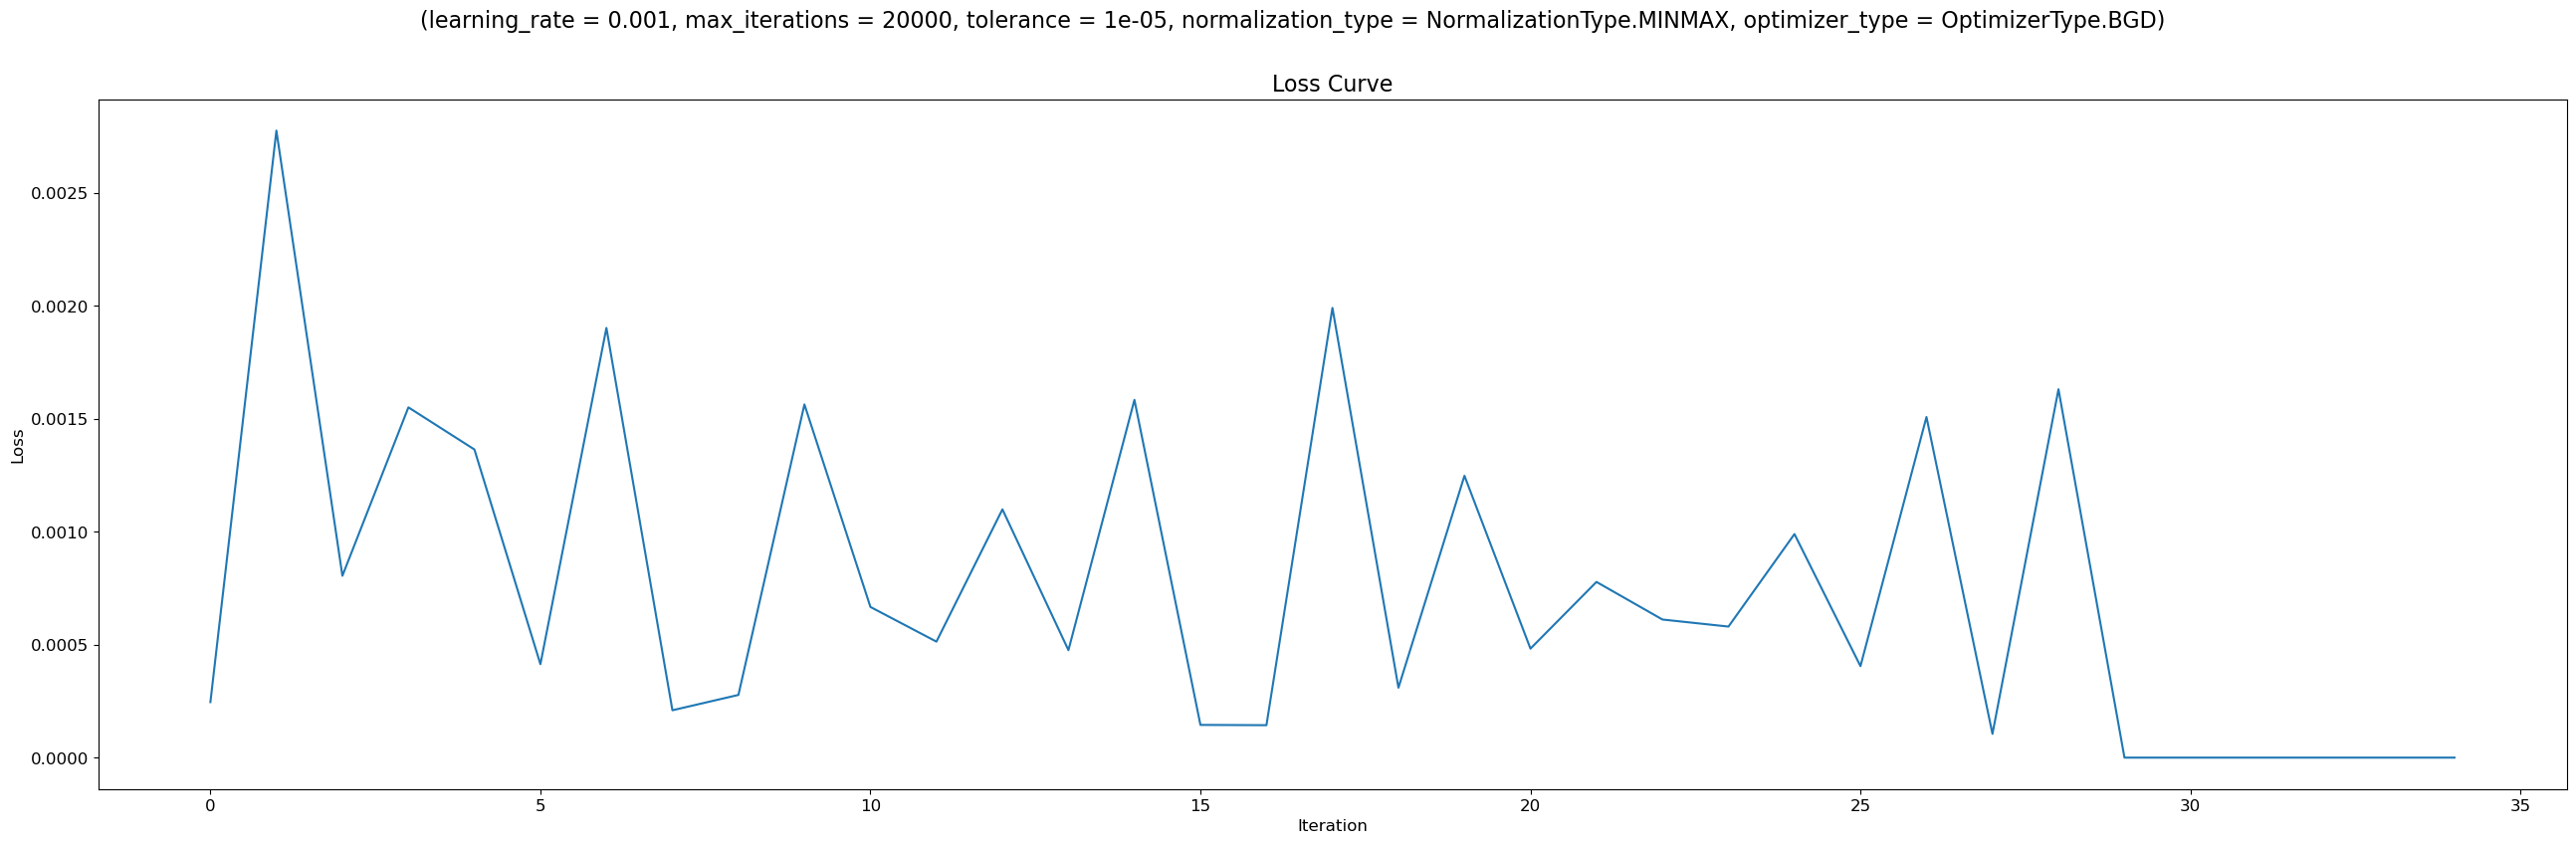

In [1074]:
model = BinaryPerceptron(
    dim = X_train.shape[1],
    learning_rate = 0.001,
    max_iterations = 20000,
    tolerance = 1e-5,
    no_improve_threshold = 5,
    normalization_type = NormalizationType.MINMAX,
    optimizer_type = OptimizerType.BGD
)
model.optimize(X_train, t_train)
show_results(model, X_train, t_train, X_test, y_test, show_plot = True)

The result is perfect in this case, with 100% accuracy, recall, precision, and f1_score.